In [1]:
from src.model.eegnet_variance import EEGNetMultiHeaded
from pytorch_lightning.loggers import CometLogger
from src.datamodule import DataModule, predictDataSet
from src.preprocessing import create_dataset
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from src.preprocessing import *
from src.noise_addition import zero_signal, add_gaussian_noise
import copy
import random
import pickle

In [2]:
comet_logger = CometLogger(
    api_key="WSATCNWE43zphHslQCTsJKcgk",
    workspace="marwo22",  # Optional
    project_name="bachelors-project"  # Optional
)

CometLogger will be initialized in online mode


In [3]:
def add_guassian_noise_to_dataset(dataset, severity_index, low: int = 0, high: int = 308):
    if (severity_index == 0):
        return dataset

    length = len(dataset[0])
        # Add noise to 7.5%  * severityIndex of samples in the dataset. It can thus range from 5% to 50%
    episodes_to_corrupt = random.sample(range(0, length), int(0.1 * severity_index * length))
        # Add noise to the samples
    for episode in episodes_to_corrupt:
        channels_to_corrupt = int(64 / 10 * severity_index)
        dataset[0][episode] = add_gaussian_noise(dataset[0][episode], 2 * severity_index, channels_to_corrupt, low, high)

    return dataset

In [4]:
def add_zero_to_dataset(dataset, severity_index, low: int = 0, high: int = 308):
    if (severity_index == 0):
        return dataset
    
    length = len(dataset[0])
        # Add noise to 7.5%  * severityIndex of samples in the dataset. It can thus range from 5% to 50%
    episodes_to_corrupt = random.sample(range(0, length), int(0.1 * severity_index * length))
        # Add noise to the samples
    for episode in episodes_to_corrupt:
            # Can range from 5-50%
        channels_to_corrupt = int(64 / 20 * severity_index)
            # Zeroes the entire signal
        dataset[0][episode] = zero_signal(dataset[0][episode], channels_to_corrupt, low, high, 100)

    return dataset

Text(0.5, 0.98, 'The effect of strong localized noise on the first 5 channels')

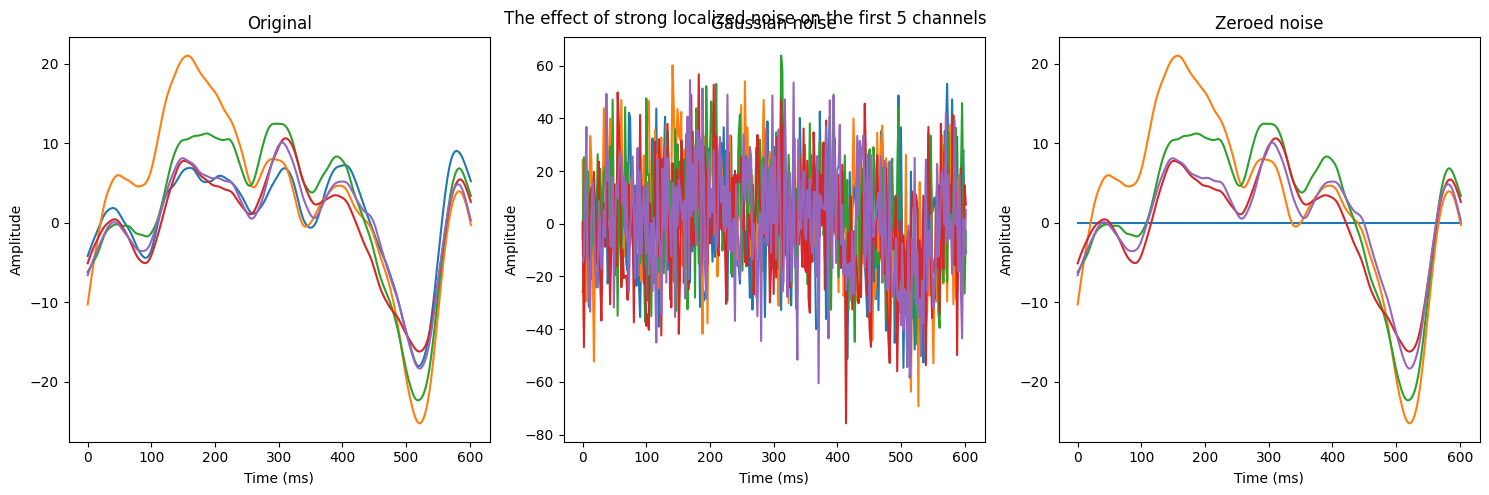

In [5]:
# Plot the first 5 channels of the original signal, localized noise on 0-250ms, and localized noise on 250-500ms

train, val, test = create_dataset('./src/pickle_df', 1)

train_copy = copy.deepcopy(train)
guassian = add_guassian_noise_to_dataset(train_copy, 10)

train_copy = copy.deepcopy(train)
zeroed = add_zero_to_dataset(train_copy, 10)

duration = 308 / 512 * 1000
t = np.linspace(0, duration, 308)

figure, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(t, train[0][0][0], label='1')
axes[0].plot(t, train[0][0][1], label='2')
axes[0].plot(t, train[0][0][2], label="3")
axes[0].plot(t, train[0][0][3], label="4")
axes[0].plot(t, train[0][0][4], label="5")
axes[0].set_xlabel("Time (ms)")
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Original")

axes[1].plot(t, guassian[0][0][0], label='1')
axes[1].plot(t, guassian[0][0][1], label='2')
axes[1].plot(t, guassian[0][0][2], label="3")
axes[1].plot(t, guassian[0][0][3], label="4")
axes[1].plot(t, guassian[0][0][4], label="5")
axes[1].set_xlabel("Time (ms)")
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Gaussian noise")

axes[2].plot(t, zeroed[0][0][0], label='1')
axes[2].plot(t, zeroed[0][0][1], label='2')
axes[2].plot(t, zeroed[0][0][2], label="3")
axes[2].plot(t, zeroed[0][0][3], label="4")
axes[2].plot(t, zeroed[0][0][4], label="5")
axes[2].set_xlabel("Time (ms)")
axes[2].set_ylabel("Amplitude")
axes[2].set_title("Zeroed noise")

figure.tight_layout()
figure.suptitle("The effect of strong localized noise on the first 5 channels")
# Title and subtitle overlap, but its only for visualization

In [9]:
variances = [[] for _ in range(11)]
accuracies = [[] for _ in range(11)]

for j in range(6):  
    # Load in the datasets with the current participant as test set
    train, val, test = create_dataset('./src/pickle_df', j + 1)

    for i in range(11):
        # Take deep copies
        train_copy = copy.deepcopy(train)
        val_copy = copy.deepcopy(val)
        test_copy = copy.deepcopy(test)
        
        # Add noise to the deep copies. If i is 0, noise is added to the lower end, when it is 1, it is added to the higher end
        # For this experiment, the intensity value is 5, resulting in a 'medium' level of noise
        train_copy = add_guassian_noise_to_dataset(train_copy, i)
        val_copy = add_guassian_noise_to_dataset(val_copy, i)
        test_copy = add_guassian_noise_to_dataset(test_copy, i)

        dm = DataModule(train=train_copy, val=val_copy, test=test_copy, batch_size=16)

        model = EEGNetMultiHeaded(chunk_size=308,
                                num_electrodes=64,
                                dropout=0.5,
                                kernel_1=64,
                                kernel_2=16,
                                F1=8,
                                F2=16,
                                D=2,
                                num_classes=2)
        # Train for 25 epochs for this example
        # Final one for results wil run for 50 most likely
        trainer = pl.Trainer(
            max_epochs=25,
            logger=comet_logger
        )

        # Fit and test model
        trainer.fit(model, datamodule=dm)
        test_results = trainer.test(model, datamodule=dm)
        
        # Capture the testing variance and accuracy
        variances[i].append(test_results[0]['overall_var'])
        accuracies[i].append(test_results[0]['test_acc'])

        # Save them to a pkl file
        with open('results_pickled/global_variances_gaussian.pkl', 'wb') as f:
            pickle.dump(variances, f)

        with open('results_pickled/global_accuracies_gaussian.pkl', 'wb') as f:
            pickle.dump(accuracies, f)
    
    # Just to visualize progress easier, the output is very messy
    print("\n\n\n\n\nFinished" + str(j) + "\n\n\n\n\n")

KeyboardInterrupt: 

In [6]:
variances = [[] for _ in range(11)]
accuracies = [[] for _ in range(11)]

for j in range(6):  
    # Load in the datasets with the current participant as test set
    train, val, test = create_dataset('./src/pickle_df', j + 1)

    for i in range(11):
        # Take deep copies
        train_copy = copy.deepcopy(train)
        val_copy = copy.deepcopy(val)
        test_copy = copy.deepcopy(test)
        
        # Add noise to the deep copies. If i is 0, noise is added to the lower end, when it is 1, it is added to the higher end
        # For this experiment, the intensity value is 5, resulting in a 'medium' level of noise
        train_copy = add_zero_to_dataset(train_copy, 10)
        val_copy = add_zero_to_dataset(val_copy, 10)
        test_copy = add_zero_to_dataset(test_copy, 10)

        dm = DataModule(train=train_copy, val=val_copy, test=test_copy, batch_size=16)

        model = EEGNetMultiHeaded(chunk_size=308,
                                num_electrodes=64,
                                dropout=0.5,
                                kernel_1=64,
                                kernel_2=16,
                                F1=8,
                                F2=16,
                                D=2,
                                num_classes=2)
        # Train for 25 epochs for this example
        # Final one for results wil run for 50 most likely
        trainer = pl.Trainer(
            max_epochs=25,
            logger=comet_logger
        )

        # Fit and test model
        trainer.fit(model, datamodule=dm)
        test_results = trainer.test(model, datamodule=dm)
        
        # Capture the testing variance and accuracy
        variances[i].append(test_results[0]['overall_var'])
        accuracies[i].append(test_results[0]['test_acc'])

        # Save them to a pkl file
        with open('results_pickled/global_variances_zeroed.pkl', 'wb') as f:
            pickle.dump(variances, f)

        with open('results_pickled/global_accuracies_zeroed.pkl', 'wb') as f:
            pickle.dump(accuracies, f)
    
    # Just to visualize progress easier, the output is very messy
    print("\n\n\n\n\nFinished" + str(j) + "\n\n\n\n\n")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 78.65it/s, v_num=052c]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 78.55it/s, v_num=052c]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (7.598080158233643, 23883.12890625)
COMET INFO:     val_loss [1702]    : (-2.057532548904419, 188.02931213378906)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2.52 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO

Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 86.06it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 28.94it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.16922449389132843    │
│       incorrect_var       │    0.16895279132129307    │
│        overall_var        │    0.16913770139217377    │
│         test_acc          │     0.774904191493988     │
│         test_loss         │    14.957216262817383     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.16922449389132843
COMET INFO:     incorrect_var : 0.16895279132129307
COMET INFO:     overall_var   : 0.16913770139217377
COMET INFO:     test_acc      : 0.774904191493988
COMET INFO:     test_loss     : 14.957216262817383
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 82.88it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 82.73it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):


COMET INFO:     train_loss [10800] : (7.665463447570801, 61.5933952331543)
COMET INFO:     val_loss [1702]    : (6.25455379486084, 45.658329010009766)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 84.73it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.00it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │     0.227201000661439     │
│       incorrect_var       │    0.24044930621277483    │
│        overall_var        │    0.2295333296060562     │
│         test_acc          │    0.8218390941619873     │
│         test_loss         │    12.425107955932617     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.227201000661439
COMET INFO:     incorrect_var : 0.24044930621277483
COMET INFO:     overall_var   : 0.2295333296060562
COMET INFO:     test_acc      : 0.8218390941619873
COMET INFO:     test_loss     : 12.425107955932617
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 85.17it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 85.04it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (8.380281448364258, 55.43244934082031)
COMET INFO:     val_loss [1702]    : (6.142021179199219, 48.72200393676758)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 91.91it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.51it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22658451542124727    │
│       incorrect_var       │    0.24031235678959145    │
│        overall_var        │    0.2289486676454544     │
│         test_acc          │    0.8208812475204468     │
│         test_loss         │    12.405019760131836     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22658451542124727
COMET INFO:     incorrect_var : 0.24031235678959145
COMET INFO:     overall_var   : 0.2289486676454544
COMET INFO:     test_acc      : 0.8208812475204468
COMET INFO:     test_loss     : 12.405019760131836
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 75.76it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 75.64it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:


COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (9.288717269897461, 142.83499145507812)
COMET INFO:     val_loss [1702]    : (6.4937896728515625, 48.15040969848633)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 84.41it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 28.64it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2360194487154497     │
│       incorrect_var       │    0.24212044596959206    │
│        overall_var        │    0.23711954057216644    │
│         test_acc          │    0.8342911601066589     │
│         test_loss         │    13.027640342712402     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2360194487154497
COMET INFO:     incorrect_var : 0.24212044596959206
COMET INFO:     overall_var   : 0.23711954057216644
COMET INFO:     test_acc      : 0.8342911601066589
COMET INFO:     test_loss     : 13.027640342712402
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 82.61it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 82.47it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (5.591814041137695, 41502.52734375)
COMET INFO:     val_loss [1702]    : (17.075143814086914, 182.76776123046875)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 82.09it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 28.45it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20231258290546653    │
│       incorrect_var       │    0.19874790689176958    │
│        overall_var        │    0.19931459426879883    │
│         test_acc          │    0.22557471692562103    │
│         test_loss         │    33.985313415527344     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20231258290546653
COMET INFO:     incorrect_var : 0.19874790689176958
COMET INFO:     overall_var   : 0.19931459426879883
COMET INFO:     test_acc      : 0.22557471692562103
COMET INFO:     test_loss     : 33.985313415527344
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: Tr

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 82.60it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 82.46it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (7.259678363800049, 56.57401657104492)
COMET INFO:     val_loss [1702]    : (5.189385414123535, 48.95490264892578)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 80.79it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 28.66it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2194856020666941     │
│       incorrect_var       │    0.23689541679131923    │
│        overall_var        │    0.22224506735801697    │
│         test_acc          │    0.8467432856559753     │
│         test_loss         │    11.435489654541016     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2194856020666941
COMET INFO:     incorrect_var : 0.23689541679131923
COMET INFO:     overall_var   : 0.22224506735801697
COMET INFO:     test_acc      : 0.8467432856559753
COMET INFO:     test_loss     : 11.435489654541016
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 83.20it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 83.05it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (6.9508867263793945, 54.888526916503906)
COMET INFO:     val_loss [1702]    : (5.837699890136719, 53.1121826171875)


COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 81.59it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 28.65it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22584955905889914    │
│       incorrect_var       │     0.237396412797939     │
│        overall_var        │    0.2284446358680725     │
│         test_acc          │     0.803639829158783     │
│         test_loss         │    12.632768630981445     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22584955905889914
COMET INFO:     incorrect_var : 0.237396412797939
COMET INFO:     overall_var   : 0.2284446358680725
COMET INFO:     test_acc      : 0.803639829158783
COMET INFO:     test_loss     : 12.632768630981445
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
TPU

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 82.50it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 82.38it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (7.823646545410156, 55.33208465576172)
COMET INFO:     val_loss [1702]    : (5.679652214050293, 48.27253341674805)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 88.21it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2240790614122678     │
│       incorrect_var       │    0.2393896358187801     │
│        overall_var        │    0.22705920040607452    │
│         test_acc          │    0.7988505959510803     │
│         test_loss         │    12.444036483764648     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2240790614122678
COMET INFO:     incorrect_var : 0.2393896358187801
COMET INFO:     overall_var   : 0.22705920040607452
COMET INFO:     test_acc      : 0.7988505959510803
COMET INFO:     test_loss     : 12.444036483764648
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 83.04it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 82.87it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (7.72810173034668, 48.87400817871094)
COMET INFO:     val_loss [1702]    : (5.9981255531311035, 56.20771408081055)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 92.93it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 30.26it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21932606230370574    │
│       incorrect_var       │    0.23602663866584264    │
│        overall_var        │    0.2222575694322586     │
│         test_acc          │    0.8275862336158752     │
│         test_loss         │    11.762964248657227     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21932606230370574
COMET INFO:     incorrect_var : 0.23602663866584264
COMET INFO:     overall_var   : 0.2222575694322586
COMET INFO:     test_acc      : 0.8275862336158752
COMET INFO:     test_loss     : 11.762964248657227
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 81.73it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 81.58it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (8.421110153198242, 55.24575424194336)
COMET INFO:     val_loss [1702]    : (6.085041522979736, 52.35070037841797)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 83.01it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 28.11it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22539605826939074    │
│       incorrect_var       │    0.23922717666477578    │
│        overall_var        │    0.2274961918592453     │
│         test_acc          │    0.8295019268989563     │
│         test_loss         │     12.28779125213623     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22539605826939074
COMET INFO:     incorrect_var : 0.23922717666477578
COMET INFO:     overall_var   : 0.2274961918592453
COMET INFO:     test_acc      : 0.8295019268989563
COMET INFO:     test_loss     : 12.28779125213623
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 78.94it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 78.81it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (7.775699615478516, 58.26788330078125)
COMET INFO:     val_loss [1702]    : (6.490506172180176, 49.54354476928711)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 86.61it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.39it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2229183734662554     │
│       incorrect_var       │    0.23788936791631082    │
│        overall_var        │    0.22523397207260132    │
│         test_acc          │    0.8295019268989563     │
│         test_loss         │    12.018899917602539     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2229183734662554
COMET INFO:     incorrect_var : 0.23788936791631082
COMET INFO:     overall_var   : 0.22523397207260132
COMET INFO:     test_acc      : 0.8295019268989563
COMET INFO:     test_loss     : 12.018899917602539
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished0







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\be25f1fe07eb4fffa78a31d344ca052c\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 83.73it/s, v_num=052c]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 83.60it/s, v_num=052c]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10725] : (6.071208953857422, 65.06438446044922)
COMET INFO:     val_loss [1702]    : (2.6363868713378906, 50.693328857421875)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\p

Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 95.42it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 30.95it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2237277458766404     │
│       incorrect_var       │    0.2361998131682002     │
│        overall_var        │    0.22726623713970184    │
│         test_acc          │    0.7074074149131775     │
│         test_loss         │    14.151808738708496     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2237277458766404
COMET INFO:     incorrect_var : 0.2361998131682002
COMET INFO:     overall_var   : 0.22726623713970184
COMET INFO:     test_acc      : 0.7074074149131775
COMET INFO:     test_loss     : 14.151808738708496
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 82.04it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 81.90it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):


COMET INFO:     train_loss [10725] : (6.54213809967041, 56.62017059326172)
COMET INFO:     val_loss [1702]    : (3.0867223739624023, 50.151527404785156)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 90.78it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 29.37it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21862041511760652    │
│       incorrect_var       │    0.2341997358209289     │
│        overall_var        │    0.22249089181423187    │
│         test_acc          │    0.7592592835426331     │
│         test_loss         │    13.161134719848633     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21862041511760652
COMET INFO:     incorrect_var : 0.2341997358209289
COMET INFO:     overall_var   : 0.22249089181423187
COMET INFO:     test_acc      : 0.7592592835426331
COMET INFO:     test_loss     : 13.161134719848633
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 81.18it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 81.06it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10725] : (6.5652594566345215, 52.84984588623047)
COMET INFO:     val_loss [1702]    : (2.9437570571899414, 48.35431671142578)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 92.87it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 30.00it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2220109062018091     │
│       incorrect_var       │    0.23658702763084746    │
│        overall_var        │    0.2256573885679245     │
│         test_acc          │    0.7527777552604675     │
│         test_loss         │    13.154891967773438     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2220109062018091
COMET INFO:     incorrect_var : 0.23658702763084746
COMET INFO:     overall_var   : 0.2256573885679245
COMET INFO:     test_acc      : 0.7527777552604675
COMET INFO:     test_loss     : 13.154891967773438
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 81.08it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 80.96it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10725] : (5.885457992553711, 51.97209930419922)


COMET INFO:     val_loss [1702]    : (2.613457679748535, 51.60972595214844)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 89.51it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 30.03it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21562910641546965    │
│       incorrect_var       │    0.23102173174020313    │
│        overall_var        │    0.2197757512331009     │
│         test_acc          │     0.739814817905426     │
│         test_loss         │    13.531559944152832     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21562910641546965
COMET INFO:     incorrect_var : 0.23102173174020313
COMET INFO:     overall_var   : 0.2197757512331009
COMET INFO:     test_acc      : 0.739814817905426
COMET INFO:     test_loss     : 13.531559944152832
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 82.14it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 82.02it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):


COMET INFO:     train_loss [10725] : (5.565771102905273, 55.97385025024414)
COMET INFO:     val_loss [1702]    : (2.7841999530792236, 49.59349060058594)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 92.54it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 30.00it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22082398325305808    │
│       incorrect_var       │    0.2352367111572724     │
│        overall_var        │    0.2249317169189453     │
│         test_acc          │    0.7231481671333313     │
│         test_loss         │    13.657108306884766     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22082398325305808
COMET INFO:     incorrect_var : 0.2352367111572724
COMET INFO:     overall_var   : 0.2249317169189453
COMET INFO:     test_acc      : 0.7231481671333313
COMET INFO:     test_loss     : 13.657108306884766
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 79.68it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 79.57it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):


COMET INFO:     train_loss [10725] : (6.594708442687988, 65.78532409667969)
COMET INFO:     val_loss [1702]    : (2.868727445602417, 52.19355010986328)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 90.22it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 30.21it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21898550509397569    │
│       incorrect_var       │    0.23232356011048777    │
│        overall_var        │    0.22273342311382294    │
│         test_acc          │    0.7111111283302307     │
│         test_loss         │    14.023283004760742     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21898550509397569
COMET INFO:     incorrect_var : 0.23232356011048777
COMET INFO:     overall_var   : 0.22273342311382294
COMET INFO:     test_acc      : 0.7111111283302307
COMET INFO:     test_loss     : 14.023283004760742
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 81.30it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 81.16it/s, v_num=052c]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10725] : (6.738195896148682, 69.51878356933594)
COMET INFO:     val_loss [1702]    : (4.020623207092285, 45.87986755371094)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 93.82it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 30.59it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2186679680184187     │
│       incorrect_var       │    0.23141440753530998    │
│        overall_var        │    0.22204576432704926    │
│         test_acc          │    0.7194444537162781     │
│         test_loss         │    13.997943878173828     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2186679680184187
COMET INFO:     incorrect_var : 0.23141440753530998
COMET INFO:     overall_var   : 0.22204576432704926
COMET INFO:     test_acc      : 0.7194444537162781
COMET INFO:     test_loss     : 13.997943878173828
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 84.74it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 84.61it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1


COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10725] : (6.977371692657471, 50.23571014404297)
COMET INFO:     val_loss [1702]    : (3.3483738899230957, 50.07118606567383)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 94.34it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 30.05it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21753441392200654    │
│       incorrect_var       │    0.23219589161988816    │
│        overall_var        │    0.22088998556137085    │
│         test_acc          │    0.7638888955116272     │
│         test_loss         │    13.191081047058105     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21753441392200654
COMET INFO:     incorrect_var : 0.23219589161988816
COMET INFO:     overall_var   : 0.22088998556137085
COMET INFO:     test_acc      : 0.7638888955116272
COMET INFO:     test_loss     : 13.191081047058105
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 429/429 [00:04<00:00, 88.32it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 429/429 [00:04<00:00, 88.18it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10725] : (5.792816638946533, 54.659912109375)
COMET INFO:     val_loss [1702]    : (2.9168763160705566, 48.963645935058594)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 81.53it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 29.19it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2211761449426515     │
│       incorrect_var       │    0.2329869528330847     │
│        overall_var        │    0.22424563765525818    │
│         test_acc          │    0.7361111044883728     │
│         test_loss         │    13.761680603027344     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2211761449426515
COMET INFO:     incorrect_var : 0.2329869528330847
COMET INFO:     overall_var   : 0.22424563765525818
COMET INFO:     test_acc      : 0.7361111044883728
COMET INFO:     test_loss     : 13.761680603027344
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 429/429 [00:04<00:00, 88.18it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 429/429 [00:04<00:00, 88.00it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10725] : (6.547198295593262, 48.00830841064453)
COMET INFO:     val_loss [1702]    : (2.238696575164795, 52.912025451660156)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 96.69it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 30.56it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21812185366796027    │
│       incorrect_var       │    0.2343961303338172     │
│        overall_var        │    0.22131100296974182    │
│         test_acc          │    0.7888888716697693     │
│         test_loss         │    12.595860481262207     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21812185366796027
COMET INFO:     incorrect_var : 0.2343961303338172
COMET INFO:     overall_var   : 0.22131100296974182
COMET INFO:     test_acc      : 0.7888888716697693
COMET INFO:     test_loss     : 12.595860481262207
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 83.38it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 83.24it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10725] : (6.336901664733887, 53.637916564941406)
COMET INFO:     val_loss [1702]    : (3.5905044078826904, 50.54793167114258)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning


COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 96.48it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 30.75it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21175931520313995    │
│       incorrect_var       │    0.23233882235722772    │
│        overall_var        │    0.21709756553173065    │
│         test_acc          │    0.7509258985519409     │
│         test_loss         │     12.8837251663208      │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21175931520313995
COMET INFO:     incorrect_var : 0.23233882235722772
COMET INFO:     overall_var   : 0.21709756553173065
COMET INFO:     test_acc      : 0.7509258985519409
COMET INFO:     test_loss     : 12.8837251663208
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished1







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\be25f1fe07eb4fffa78a31d344ca052c\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 80.37it/s, v_num=052c]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 80.20it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (4.791787147521973, 46.21208190917969)
COMET INFO:     val_loss [1727]    : (4.7590227127075195, 50.4027099609375)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 467 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 77.54it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 27.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22953802262376485    │
│       incorrect_var       │    0.23775269336596186    │
│        overall_var        │    0.2317395657300949     │
│         test_acc          │     0.700772225856781     │
│         test_loss         │    14.574963569641113     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22953802262376485
COMET INFO:     incorrect_var : 0.23775269336596186
COMET INFO:     overall_var   : 0.2317395657300949
COMET INFO:     test_acc      : 0.700772225856781
COMET INFO:     test_loss     : 14.574963569641113
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 77.80it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 77.68it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (4.394040584564209, 61.57905197143555)
COMET INFO:     val_loss [1727]    : (3.861144542694092, 50.34832763671875)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 465 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 93.75it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 29.84it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │     0.216766373078932     │
│       incorrect_var       │    0.22939716242959246    │
│        overall_var        │    0.22040176391601562    │
│         test_acc          │    0.6940154433250427     │
│         test_loss         │    14.655452728271484     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.216766373078932
COMET INFO:     incorrect_var : 0.22939716242959246
COMET INFO:     overall_var   : 0.22040176391601562
COMET INFO:     test_acc      : 0.6940154433250427
COMET INFO:     test_loss     : 14.655452728271484
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 83.12it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 82.99it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (3.287388563156128, 51.660850524902344)
COMET INFO:     val_loss [1727]    : (3.638188123703003, 48.369590759277344)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 465 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 91.38it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 29.64it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21569658896059998    │
│       incorrect_var       │    0.22895441978251563    │
│        overall_var        │    0.2190835177898407     │
│         test_acc          │    0.7249034643173218     │
│         test_loss         │    13.965961456298828     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21569658896059998
COMET INFO:     incorrect_var : 0.22895441978251563
COMET INFO:     overall_var   : 0.2190835177898407
COMET INFO:     test_acc      : 0.7249034643173218
COMET INFO:     test_loss     : 13.965961456298828
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 85.53it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 85.39it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (4.258513450622559, 59.793087005615234)
COMET INFO:     val_loss [1727]    : (4.566061973571777, 48.87547302246094)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning


COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 465 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 82.01it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 28.53it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2195739042639171     │
│       incorrect_var       │    0.22900796190054043    │
│        overall_var        │    0.22195832431316376    │
│         test_acc          │    0.7055984735488892     │
│         test_loss         │    14.807465553283691     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2195739042639171
COMET INFO:     incorrect_var : 0.22900796190054043
COMET INFO:     overall_var   : 0.22195832431316376
COMET INFO:     test_acc      : 0.7055984735488892
COMET INFO:     test_loss     : 14.807465553283691
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 80.85it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 80.74it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (4.554736614227295, 53.71044158935547)
COMET INFO:     val_loss [1727]    : (4.774026393890381, 50.89735794067383)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 464 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 91.90it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 29.69it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20586021562594767    │
│       incorrect_var       │    0.22254752184805973    │
│        overall_var        │    0.2101801335811615     │
│         test_acc          │    0.7345559597015381     │
│         test_loss         │    13.823786735534668     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20586021562594767
COMET INFO:     incorrect_var : 0.22254752184805973
COMET INFO:     overall_var   : 0.2101801335811615
COMET INFO:     test_acc      : 0.7345559597015381
COMET INFO:     test_loss     : 13.823786735534668
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 84.25it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 84.10it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (4.245953559875488, 65.35736083984375)
COMET INFO:     val_loss [1727]    : (4.2059431076049805, 52.75737762451172)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 465 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 90.12it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 29.68it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22429890549798093    │
│       incorrect_var       │    0.23183788158137703    │
│        overall_var        │    0.22644741833209991    │
│         test_acc          │    0.6756756901741028     │
│         test_loss         │    15.359153747558594     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22429890549798093
COMET INFO:     incorrect_var : 0.23183788158137703
COMET INFO:     overall_var   : 0.22644741833209991
COMET INFO:     test_acc      : 0.6756756901741028
COMET INFO:     test_loss     : 15.359153747558594
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 82.95it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 82.82it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (4.162202835083008, 51.18528747558594)
COMET INFO:     val_loss [1727]    : (4.177517890930176, 48.845767974853516)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 465 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 80.44it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 28.17it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2147454583823224     │
│       incorrect_var       │    0.2306596950154753     │
│        overall_var        │    0.21849989891052246    │
│         test_acc          │    0.7249034643173218     │
│         test_loss         │     13.76257610321045     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2147454583823224
COMET INFO:     incorrect_var : 0.2306596950154753
COMET INFO:     overall_var   : 0.21849989891052246
COMET INFO:     test_acc      : 0.7249034643173218
COMET INFO:     test_loss     : 13.76257610321045
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
TP

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 85.97it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 85.75it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (6.750619888305664, 192.5666046142578)
COMET INFO:     val_loss [1727]    : (5.004279136657715, 50.548213958740234)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 464 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 90.19it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 29.57it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.24600819047620087    │
│       incorrect_var       │    0.24713271601973638    │
│        overall_var        │    0.24649392068386078    │
│         test_acc          │    0.5965250730514526     │
│         test_loss         │     16.05860137939453     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.24600819047620087
COMET INFO:     incorrect_var : 0.24713271601973638
COMET INFO:     overall_var   : 0.24649392068386078
COMET INFO:     test_acc      : 0.5965250730514526
COMET INFO:     test_loss     : 16.05860137939453
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 86.95it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 86.81it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (4.744175434112549, 61.58333969116211)
COMET INFO:     val_loss [1727]    : (4.380619049072266, 49.430110931396484)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 465 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 95.19it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 29.67it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22218834677593668    │
│       incorrect_var       │    0.2309196698737504     │
│        overall_var        │    0.22439253330230713    │
│         test_acc          │    0.7104247212409973     │
│         test_loss         │    14.674272537231445     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22218834677593668
COMET INFO:     incorrect_var : 0.2309196698737504
COMET INFO:     overall_var   : 0.22439253330230713
COMET INFO:     test_acc      : 0.7104247212409973
COMET INFO:     test_loss     : 14.674272537231445
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 86.26it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 86.10it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (4.6892595291137695, 49.28938293457031)
COMET INFO:     val_loss [1727]    : (5.138134956359863, 55.016090393066406)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 465 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 93.55it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 29.66it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21493108859163523    │
│       incorrect_var       │    0.22583589674087032    │
│        overall_var        │    0.2180168330669403     │
│         test_acc          │    0.7123551964759827     │
│         test_loss         │    14.592510223388672     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21493108859163523
COMET INFO:     incorrect_var : 0.22583589674087032
COMET INFO:     overall_var   : 0.2180168330669403
COMET INFO:     test_acc      : 0.7123551964759827
COMET INFO:     test_loss     : 14.592510223388672
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 86.73it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 86.57it/s, v_num=052c]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (4.374144077301025, 52.12396240234375)
COMET INFO:     val_loss [1727]    : (4.155200004577637, 48.58539581298828)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 95.04it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 29.77it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22188787614084968    │
│       incorrect_var       │    0.2299138729686961     │
│        overall_var        │    0.2238207310438156     │
│         test_acc          │     0.700772225856781     │
│         test_loss         │    15.018186569213867     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22188787614084968
COMET INFO:     incorrect_var : 0.2299138729686961
COMET INFO:     overall_var   : 0.2238207310438156
COMET INFO:     test_acc      : 0.700772225856781
COMET INFO:     test_loss     : 15.018186569213867
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages







Finished2







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\be25f1fe07eb4fffa78a31d344ca052c\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 430/430 [00:06<00:00, 70.64it/s, v_num=052c]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 430/430 [00:06<00:00, 70.53it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:


COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10750] : (5.605329513549805, 13840.548828125)
COMET INFO:     val_loss [1627]    : (5.211891174316406, 49.575294494628906)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 393 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on thi

Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 88.37it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 28.73it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.19685548153169866    │
│       incorrect_var       │    0.19726128058083733    │
│        overall_var        │    0.19698098301887512    │
│         test_acc          │    0.7994296550750732     │
│         test_loss         │    12.707436561584473     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.19685548153169866
COMET INFO:     incorrect_var : 0.19726128058083733
COMET INFO:     overall_var   : 0.19698098301887512
COMET INFO:     test_acc      : 0.7994296550750732
COMET INFO:     test_loss     : 12.707436561584473
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 430/430 [00:04<00:00, 92.55it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 430/430 [00:04<00:00, 92.38it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10750] : (5.799529552459717, 47.77436828613281)
COMET INFO:     val_loss [1627]    : (6.538610458374023, 50.83440399169922)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 392 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 85.78it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 28.33it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20981274755709667    │
│       incorrect_var       │    0.22928545915451987    │
│        overall_var        │    0.2138533592224121     │
│         test_acc          │    0.7804182767868042     │
│         test_loss         │     12.16545295715332     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20981274755709667
COMET INFO:     incorrect_var : 0.22928545915451987
COMET INFO:     overall_var   : 0.2138533592224121
COMET INFO:     test_acc      : 0.7804182767868042
COMET INFO:     test_loss     : 12.16545295715332
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 430/430 [00:04<00:00, 93.46it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 430/430 [00:04<00:00, 93.32it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10750] : (5.5259108543396, 50.674102783203125)
COMET INFO:     val_loss [1627]    : (6.428684234619141, 49.00636291503906)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 392 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 104.85it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 30.58it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21204547093537263    │
│       incorrect_var       │    0.22847787001430972    │
│        overall_var        │    0.21590113639831543    │
│         test_acc          │     0.769961953163147     │
│         test_loss         │    12.536219596862793     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21204547093537263
COMET INFO:     incorrect_var : 0.22847787001430972
COMET INFO:     overall_var   : 0.21590113639831543
COMET INFO:     test_acc      : 0.769961953163147
COMET INFO:     test_loss     : 12.536219596862793
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 430/430 [00:04<00:00, 93.65it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 430/430 [00:04<00:00, 93.49it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10750] : (6.095197677612305, 54.709686279296875)


COMET INFO:     val_loss [1627]    : (6.21103572845459, 52.82830810546875)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 392 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 103.55it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 31.52it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20885323493248198    │
│       incorrect_var       │    0.2273381211966315     │
│        overall_var        │    0.21300344169139862    │
│         test_acc          │    0.7832699418067932     │
│         test_loss         │    12.215326309204102     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20885323493248198
COMET INFO:     incorrect_var : 0.2273381211966315
COMET INFO:     overall_var   : 0.21300344169139862
COMET INFO:     test_acc      : 0.7832699418067932
COMET INFO:     test_loss     : 12.215326309204102
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 430/430 [00:04<00:00, 93.78it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 430/430 [00:04<00:00, 93.64it/s, v_num=052c]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10750] : (5.978846549987793, 50.402801513671875)
COMET INFO:     val_loss [1627]    : (7.479422092437744, 48.498565673828125)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 392 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 105.69it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 31.26it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20887745613585654    │
│       incorrect_var       │    0.22717953653557238    │
│        overall_var        │    0.21304473280906677    │
│         test_acc          │    0.7766159772872925     │
│         test_loss         │    12.515533447265625     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20887745613585654
COMET INFO:     incorrect_var : 0.22717953653557238
COMET INFO:     overall_var   : 0.21304473280906677
COMET INFO:     test_acc      : 0.7766159772872925
COMET INFO:     test_loss     : 12.515533447265625
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: Tru

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 430/430 [00:04<00:00, 95.05it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 430/430 [00:04<00:00, 94.91it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10750] : (6.6265411376953125, 49.117034912109375)
COMET INFO:     val_loss [1627]    : (5.33506441116333, 51.5254020690918)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning


COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 392 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 100.63it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 30.90it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2225619293499763     │
│       incorrect_var       │    0.2350644365717414     │
│        overall_var        │    0.22520564496517181    │
│         test_acc          │    0.7832699418067932     │
│         test_loss         │    12.871955871582031     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2225619293499763
COMET INFO:     incorrect_var : 0.2350644365717414
COMET INFO:     overall_var   : 0.22520564496517181
COMET INFO:     test_acc      : 0.7832699418067932
COMET INFO:     test_loss     : 12.871955871582031
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 430/430 [00:04<00:00, 90.99it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 430/430 [00:04<00:00, 90.82it/s, v_num=052c]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10750] : (6.028075695037842, 45.45616912841797)
COMET INFO:     val_loss [1627]    : (5.2736101150512695, 50.36488342285156)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 392 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 101.32it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 30.72it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21587253984162996    │
│       incorrect_var       │    0.23092025121053059    │
│        overall_var        │    0.21908825635910034    │
│         test_acc          │    0.7889733910560608     │
│         test_loss         │    12.372330665588379     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21587253984162996
COMET INFO:     incorrect_var : 0.23092025121053059
COMET INFO:     overall_var   : 0.21908825635910034
COMET INFO:     test_acc      : 0.7889733910560608
COMET INFO:     test_loss     : 12.372330665588379
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: Tru

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 430/430 [00:04<00:00, 90.57it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 430/430 [00:04<00:00, 90.42it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10750] : (5.842982292175293, 46.00241470336914)
COMET INFO:     val_loss [1627]    : (6.371467113494873, 50.597618103027344)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 392 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 105.44it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 31.36it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21381388057618028    │
│       incorrect_var       │    0.22981572726254126    │
│        overall_var        │    0.2174808830022812     │
│         test_acc          │    0.7785171270370483     │
│         test_loss         │    12.502185821533203     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21381388057618028
COMET INFO:     incorrect_var : 0.22981572726254126
COMET INFO:     overall_var   : 0.2174808830022812
COMET INFO:     test_acc      : 0.7785171270370483
COMET INFO:     test_loss     : 12.502185821533203
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 430/430 [00:04<00:00, 88.28it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 430/430 [00:04<00:00, 88.14it/s, v_num=052c]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10750] : (6.887795448303223, 67.42228698730469)
COMET INFO:     val_loss [1627]    : (6.973972320556641, 50.11714172363281)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 392 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 97.37it/s] 

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 30.50it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2088809990098171     │
│       incorrect_var       │    0.2290456344392783     │
│        overall_var        │    0.21332572400569916    │
│         test_acc          │    0.7870722413063049     │
│         test_loss         │    11.967903137207031     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2088809990098171
COMET INFO:     incorrect_var : 0.2290456344392783
COMET INFO:     overall_var   : 0.21332572400569916
COMET INFO:     test_acc      : 0.7870722413063049
COMET INFO:     test_loss     : 11.967903137207031
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 430/430 [00:05<00:00, 83.47it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 430/430 [00:05<00:00, 83.27it/s, v_num=052c]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10750] : (6.551363945007324, 52.874420166015625)
COMET INFO:     val_loss [1627]    : (5.798123836517334, 49.84453201293945)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 392 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 93.83it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.76it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2084508654768915     │
│       incorrect_var       │    0.22625430516047962    │
│        overall_var        │    0.21208709478378296    │
│         test_acc          │    0.7804182767868042     │
│         test_loss         │    12.507782936096191     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2084508654768915
COMET INFO:     incorrect_var : 0.22625430516047962
COMET INFO:     overall_var   : 0.21208709478378296
COMET INFO:     test_acc      : 0.7804182767868042
COMET INFO:     test_loss     : 12.507782936096191
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 430/430 [00:05<00:00, 85.58it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 430/430 [00:05<00:00, 85.41it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10750] : (5.821467399597168, 47.748023986816406)
COMET INFO:     val_loss [1627]    : (5.495491981506348, 49.09642791748047)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 392 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 95.55it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.46it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2077899232188753     │
│       incorrect_var       │    0.22738646664261036    │
│        overall_var        │    0.21171031892299652    │
│         test_acc          │    0.7937262654304504     │
│         test_loss         │    11.902024269104004     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2077899232188753
COMET INFO:     incorrect_var : 0.22738646664261036
COMET INFO:     overall_var   : 0.21171031892299652
COMET INFO:     test_acc      : 0.7937262654304504
COMET INFO:     test_loss     : 11.902024269104004
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished3







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\be25f1fe07eb4fffa78a31d344ca052c\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 86.33it/s, v_num=052c]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 86.18it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (0.7523636221885681, 59.9162712097168)
COMET INFO:     val_loss [1652]    : (7.786703109741211, 50.5784912109375)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 152 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 79.89it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 29.75it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2231084270577409     │
│       incorrect_var       │    0.23661611790496617    │
│        overall_var        │    0.22605371475219727    │
│         test_acc          │    0.7889581322669983     │
│         test_loss         │     12.59395980834961     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2231084270577409
COMET INFO:     incorrect_var : 0.23661611790496617
COMET INFO:     overall_var   : 0.22605371475219727
COMET INFO:     test_acc      : 0.7889581322669983
COMET INFO:     test_loss     : 12.59395980834961
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 86.50it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 86.36it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c


COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (0.42653346061706543, 51.33209228515625)
COMET INFO:     val_loss [1652]    : (7.305492877960205, 58.687843322753906)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 84.23it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 30.82it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21043859944846657    │
│       incorrect_var       │    0.23220765177099606    │
│        overall_var        │    0.21453286707401276    │
│         test_acc          │    0.8076580762863159     │
│         test_loss         │    11.810196876525879     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21043859944846657
COMET INFO:     incorrect_var : 0.23220765177099606
COMET INFO:     overall_var   : 0.21453286707401276
COMET INFO:     test_acc      : 0.8076580762863159
COMET INFO:     test_loss     : 11.810196876525879
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 80.52it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 80.37it/s, v_num=052c]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (0.9689311385154724, 111.9364013671875)
COMET INFO:     val_loss [1652]    : (8.61279582977295, 108.98233032226562)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 93.16it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 30.83it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.23654483985063082    │
│       incorrect_var       │    0.24338426545693156    │
│        overall_var        │    0.2378561794757843     │
│         test_acc          │    0.7818343639373779     │
│         test_loss         │    13.652817726135254     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.23654483985063082
COMET INFO:     incorrect_var : 0.24338426545693156
COMET INFO:     overall_var   : 0.2378561794757843
COMET INFO:     test_acc      : 0.7818343639373779
COMET INFO:     test_loss     : 13.652817726135254
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 85.37it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 85.24it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (0.8636232614517212, 48.286346435546875)
COMET INFO:     val_loss [1652]    : (7.381639003753662, 45.09251022338867)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 96.05it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 30.78it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2202104130105668     │
│       incorrect_var       │    0.2347043490200154     │
│        overall_var        │    0.2230709195137024     │
│         test_acc          │    0.8067675828933716     │
│         test_loss         │    12.262102127075195     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2202104130105668
COMET INFO:     incorrect_var : 0.2347043490200154
COMET INFO:     overall_var   : 0.2230709195137024
COMET INFO:     test_acc      : 0.8067675828933716
COMET INFO:     test_loss     : 12.262102127075195
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 86.22it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 86.08it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (0.6178824305534363, 59.456787109375)
COMET INFO:     val_loss [1652]    : (8.31358528137207, 49.86833953857422)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 94.27it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 31.66it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2228444919439942     │
│       incorrect_var       │    0.23701958821757754    │
│        overall_var        │    0.22558274865150452    │
│         test_acc          │    0.7916295528411865     │
│         test_loss         │    12.644402503967285     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2228444919439942
COMET INFO:     incorrect_var : 0.23701958821757754
COMET INFO:     overall_var   : 0.22558274865150452
COMET INFO:     test_acc      : 0.7916295528411865
COMET INFO:     test_loss     : 12.644402503967285
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 86.67it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 86.53it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (0.6360141038894653, 55.76554870605469)
COMET INFO:     val_loss [1652]    : (6.97662878036499, 44.850502014160156)


COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 97.91it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 31.86it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20300278209701608    │
│       incorrect_var       │    0.22921792270634508    │
│        overall_var        │    0.20730189979076385    │
│         test_acc          │    0.8334817290306091     │
│         test_loss         │    10.742799758911133     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20300278209701608
COMET INFO:     incorrect_var : 0.22921792270634508
COMET INFO:     overall_var   : 0.20730189979076385
COMET INFO:     test_acc      : 0.8334817290306091
COMET INFO:     test_loss     : 10.742799758911133
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 83.22it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 83.08it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:


COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (0.7175871133804321, 66.20562744140625)
COMET INFO:     val_loss [1652]    : (7.620519638061523, 48.190467834472656)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:01<00:00, 66.99it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 27.94it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21210766246439197    │
│       incorrect_var       │    0.23396667682092048    │
│        overall_var        │    0.21615394949913025    │
│         test_acc          │    0.8058770895004272     │
│         test_loss         │    11.817018508911133     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21210766246439197
COMET INFO:     incorrect_var : 0.23396667682092048
COMET INFO:     overall_var   : 0.21615394949913025
COMET INFO:     test_acc      : 0.8058770895004272
COMET INFO:     test_loss     : 11.817018508911133
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: Tru

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 87.58it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 87.41it/s, v_num=052c]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (1.0775805711746216, 56.38793182373047)
COMET INFO:     val_loss [1652]    : (7.28462028503418, 46.01167297363281)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 84.38it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 30.51it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22220885297165643    │
│       incorrect_var       │     0.237258332405992     │
│        overall_var        │    0.22544458508491516    │
│         test_acc          │    0.7951914668083191     │
│         test_loss         │     12.38868522644043     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22220885297165643
COMET INFO:     incorrect_var : 0.237258332405992
COMET INFO:     overall_var   : 0.22544458508491516
COMET INFO:     test_acc      : 0.7951914668083191
COMET INFO:     test_loss     : 12.38868522644043
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 87.78it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 87.61it/s, v_num=052c]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (0.981535792350769, 63.66817855834961)
COMET INFO:     val_loss [1652]    : (8.144676208496094, 48.57476043701172)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 87.61it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 30.61it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21121674795092052    │
│       incorrect_var       │    0.23347415668829458    │
│        overall_var        │    0.21473447978496552    │
│         test_acc          │    0.8379340767860413     │
│         test_loss         │    11.102638244628906     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21121674795092052
COMET INFO:     incorrect_var : 0.23347415668829458
COMET INFO:     overall_var   : 0.21473447978496552
COMET INFO:     test_acc      : 0.8379340767860413
COMET INFO:     test_loss     : 11.102638244628906
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: Tru

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 87.63it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 87.48it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (0.6171005964279175, 49.221435546875)
COMET INFO:     val_loss [1652]    : (7.491522789001465, 55.77924728393555)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 98.87it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 32.06it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21899637033139152    │
│       incorrect_var       │    0.2351525194687294     │
│        overall_var        │    0.22188535332679749    │
│         test_acc          │    0.8165627717971802     │
│         test_loss         │     12.02711296081543     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21899637033139152
COMET INFO:     incorrect_var : 0.2351525194687294
COMET INFO:     overall_var   : 0.22188535332679749
COMET INFO:     test_acc      : 0.8165627717971802
COMET INFO:     test_loss     : 12.02711296081543
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 86.99it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 86.83it/s, v_num=052c]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (0.5902917981147766, 51.70347595214844)
COMET INFO:     val_loss [1652]    : (7.562976837158203, 48.587528228759766)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 83.00it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 30.10it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21823240749266606    │
│       incorrect_var       │    0.23534513651215752    │
│        overall_var        │    0.22144679725170135    │
│         test_acc          │     0.796972393989563     │
│         test_loss         │     12.22042179107666     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21823240749266606
COMET INFO:     incorrect_var : 0.23534513651215752
COMET INFO:     overall_var   : 0.22144679725170135
COMET INFO:     test_acc      : 0.796972393989563
COMET INFO:     test_loss     : 12.22042179107666
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished4







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\be25f1fe07eb4fffa78a31d344ca052c\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 423/423 [00:04<00:00, 86.13it/s, v_num=052c]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 423/423 [00:04<00:00, 85.99it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:


COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10575] : (4.084833145141602, 56.58893966674805)
COMET INFO:     val_loss [1652]    : (1.092567801475525, 48.1827278137207)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 20 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this

Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 100.55it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 31.74it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22312670737275433    │
│       incorrect_var       │    0.22335106988855932    │
│        overall_var        │    0.2230822592973709     │
│         test_acc          │     0.627041757106781     │
│         test_loss         │    17.590984344482422     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22312670737275433
COMET INFO:     incorrect_var : 0.22335106988855932
COMET INFO:     overall_var   : 0.2230822592973709
COMET INFO:     test_acc      : 0.627041757106781
COMET INFO:     test_loss     : 17.590984344482422
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 423/423 [00:04<00:00, 87.87it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 423/423 [00:04<00:00, 87.70it/s, v_num=052c]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10575] : (4.104257106781006, 56.545509338378906)
COMET INFO:     val_loss [1652]    : (0.9657648205757141, 49.85942840576172)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 19 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 98.75it/s] 

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 31.30it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22761598496401217    │
│       incorrect_var       │    0.2291146830214496     │
│        overall_var        │    0.2283618003129959     │
│         test_acc          │    0.5589836835861206     │
│         test_loss         │    18.067106246948242     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22761598496401217
COMET INFO:     incorrect_var : 0.2291146830214496
COMET INFO:     overall_var   : 0.2283618003129959
COMET INFO:     test_acc      : 0.5589836835861206
COMET INFO:     test_loss     : 18.067106246948242
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 423/423 [00:04<00:00, 87.87it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 423/423 [00:04<00:00, 87.69it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10575] : (3.7626309394836426, 57.102989196777344)
COMET INFO:     val_loss [1652]    : (1.1291959285736084, 49.709800720214844)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 19 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 99.89it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 31.45it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22568158065041086    │
│       incorrect_var       │    0.22696232777844538    │
│        overall_var        │    0.22604145109653473    │
│         test_acc          │    0.5789473652839661     │
│         test_loss         │     18.04370880126953     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22568158065041086
COMET INFO:     incorrect_var : 0.22696232777844538
COMET INFO:     overall_var   : 0.22604145109653473
COMET INFO:     test_acc      : 0.5789473652839661
COMET INFO:     test_loss     : 18.04370880126953
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 423/423 [00:04<00:00, 87.50it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 423/423 [00:04<00:00, 87.34it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10575] : (3.463524580001831, 63.02296447753906)
COMET INFO:     val_loss [1652]    : (1.624023675918579, 50.79644775390625)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 19 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 100.46it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 31.66it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21614870818437779    │
│       incorrect_var       │    0.21859374604231716    │
│        overall_var        │    0.21752186119556427    │
│         test_acc          │    0.6125226616859436     │
│         test_loss         │    18.174327850341797     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21614870818437779
COMET INFO:     incorrect_var : 0.21859374604231716
COMET INFO:     overall_var   : 0.21752186119556427
COMET INFO:     test_acc      : 0.6125226616859436
COMET INFO:     test_loss     : 18.174327850341797
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: Tru

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 423/423 [00:04<00:00, 87.41it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 423/423 [00:04<00:00, 87.26it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10575] : (4.68943977355957, 60.29792404174805)
COMET INFO:     val_loss [1652]    : (1.3338429927825928, 52.54320526123047)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 19 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 101.14it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 31.34it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2100771867221722     │
│       incorrect_var       │    0.21767701058654207    │
│        overall_var        │    0.21230053901672363    │
│         test_acc          │    0.6887477040290833     │
│         test_loss         │    119.56343841552734     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2100771867221722
COMET INFO:     incorrect_var : 0.21767701058654207
COMET INFO:     overall_var   : 0.21230053901672363
COMET INFO:     test_acc      : 0.6887477040290833
COMET INFO:     test_loss     : 119.56343841552734
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 423/423 [00:04<00:00, 87.30it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 423/423 [00:04<00:00, 87.15it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10575] : (2.8599700927734375, 61.92018127441406)
COMET INFO:     val_loss [1652]    : (1.0857893228530884, 50.73310089111328)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning


COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 19 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 100.54it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 31.83it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │     0.235708380472679     │
│       incorrect_var       │    0.23421699067665833    │
│        overall_var        │     0.23516845703125      │
│         test_acc          │    0.5372051000595093     │
│         test_loss         │     18.16811180114746     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.235708380472679
COMET INFO:     incorrect_var : 0.23421699067665833
COMET INFO:     overall_var   : 0.23516845703125
COMET INFO:     test_acc      : 0.5372051000595093
COMET INFO:     test_loss     : 18.16811180114746
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True
TPU 

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 423/423 [00:04<00:00, 87.13it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 423/423 [00:04<00:00, 86.97it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c


COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10575] : (3.5982847213745117, 59.22146987915039)
COMET INFO:     val_loss [1652]    : (1.921050786972046, 50.957923889160156)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 19 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 96.08it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 31.69it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2198400542018215     │
│       incorrect_var       │    0.22399926558186312    │
│        overall_var        │    0.22132785618305206    │
│         test_acc          │    0.6107078194618225     │
│         test_loss         │    17.433204650878906     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2198400542018215
COMET INFO:     incorrect_var : 0.22399926558186312
COMET INFO:     overall_var   : 0.22132785618305206
COMET INFO:     test_acc      : 0.6107078194618225
COMET INFO:     test_loss     : 17.433204650878906
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 423/423 [00:04<00:00, 87.03it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 423/423 [00:04<00:00, 86.86it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10575] : (3.527970790863037, 74.81626892089844)
COMET INFO:     val_loss [1652]    : (1.1420814990997314, 50.52464294433594)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 19 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 98.82it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 31.01it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21589241938196907    │
│       incorrect_var       │    0.21386335400049203    │
│        overall_var        │    0.21476928889751434    │
│         test_acc          │    0.5771324634552002     │
│         test_loss         │    20.195528030395508     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21589241938196907
COMET INFO:     incorrect_var : 0.21386335400049203
COMET INFO:     overall_var   : 0.21476928889751434
COMET INFO:     test_acc      : 0.5771324634552002
COMET INFO:     test_loss     : 20.195528030395508
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: Tru

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 423/423 [00:04<00:00, 87.18it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 423/423 [00:04<00:00, 87.01it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10575] : (3.733675003051758, 67.16570281982422)
COMET INFO:     val_loss [1652]    : (0.9205019474029541, 49.110267639160156)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 19 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 95.93it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 31.37it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2225966813768806     │
│       incorrect_var       │    0.22754871324316034    │
│        overall_var        │    0.22456784546375275    │
│         test_acc          │    0.5952813029289246     │
│         test_loss         │    17.315813064575195     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2225966813768806
COMET INFO:     incorrect_var : 0.22754871324316034
COMET INFO:     overall_var   : 0.22456784546375275
COMET INFO:     test_acc      : 0.5952813029289246
COMET INFO:     test_loss     : 17.315813064575195
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 423/423 [00:04<00:00, 87.39it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 423/423 [00:04<00:00, 87.23it/s, v_num=052c]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10575] : (3.695565700531006, 53.244903564453125)
COMET INFO:     val_loss [1652]    : (0.9195981025695801, 51.52581024169922)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 19 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 74.20it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 28.57it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21472928796213242    │
│       incorrect_var       │    0.22579934686051883    │
│        overall_var        │    0.21923688054084778    │
│         test_acc          │    0.6079854965209961     │
│         test_loss         │     16.79970932006836     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21472928796213242
COMET INFO:     incorrect_var : 0.22579934686051883
COMET INFO:     overall_var   : 0.21923688054084778
COMET INFO:     test_acc      : 0.6079854965209961
COMET INFO:     test_loss     : 16.79970932006836
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Epoch 24: 100%|██████████| 423/423 [00:05<00:00, 84.15it/s, v_num=052c]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 423/423 [00:05<00:00, 83.99it/s, v_num=052c]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10575] : (3.8005447387695312, 49.484886169433594)
COMET INFO:     val_loss [1652]    : (1.5783538818359375, 52.36396026611328)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 19 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 84.87it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 29.22it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20872610837230177    │
│       incorrect_var       │    0.21639841274907984    │
│        overall_var        │    0.21138790249824524    │
│         test_acc          │     0.647912859916687     │
│         test_loss         │     17.19767951965332     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/be25f1fe07eb4fffa78a31d344ca052c
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20872610837230177
COMET INFO:     incorrect_var : 0.21639841274907984
COMET INFO:     overall_var   : 0.21138790249824524
COMET INFO:     test_acc      : 0.647912859916687
COMET INFO:     test_loss     : 17.19767951965332
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages







Finished5







[0.21237674355506897, 0.22152900199095407, 0.22558139016230902, 0.22207497308651605, 0.2142257442077001, 0.2231836517651876, 0.22092672685782114, 0.2253563106060028, 0.22058729827404022, 0.22000555942455927, 0.21844954788684845]


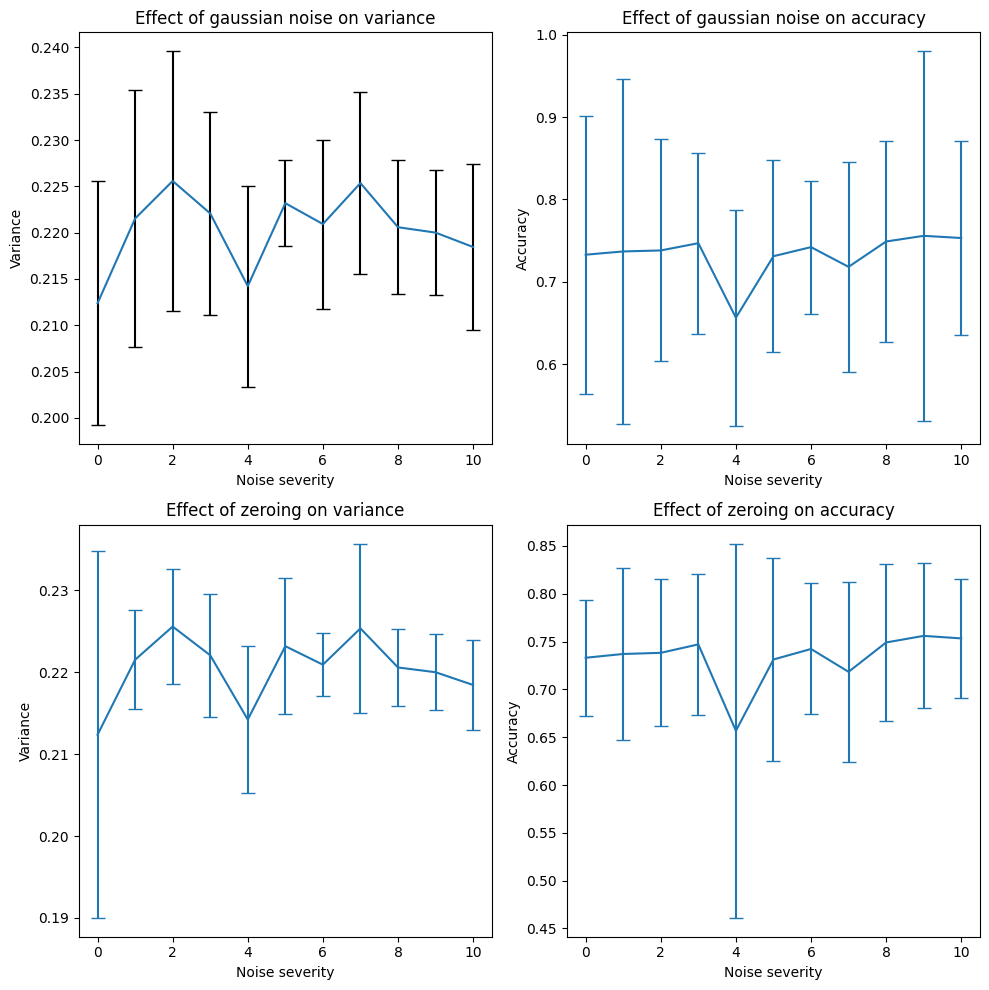

In [19]:
# Load in the .pkl files
with open('results_pickled/global_accuracies_gaussian.pkl', 'rb') as f:
    accuracies_gaussian = pickle.load(f)

with open('results_pickled/global_variances_gaussian.pkl', 'rb') as f:
    variances_gaussian = pickle.load(f)

with open('results_pickled/global_accuracies_zeroed.pkl', 'rb') as f:
    accuracies_zeroed = pickle.load(f)

with open('results_pickled/global_variances_zeroed.pkl', 'rb') as f:
    variances_zeroed = pickle.load(f)

standard_deviation_variances_gaussian = []
standard_deviation_accuracies_gaussian = []
standard_deviation_variances_zeroed = []
standard_deviation_accuracies_zeroed = []

for i in range(11):
    standard_deviation_variances_gaussian.append(np.asarray(variances_gaussian[i]).std())
    standard_deviation_accuracies_gaussian.append(np.asarray(accuracies_gaussian[i]).std())
    standard_deviation_variances_zeroed.append(np.asarray(variances_zeroed[i]).std())
    standard_deviation_accuracies_zeroed.append(np.asarray(accuracies_zeroed[i]).std())
    variances_gaussian[i] = np.asarray(variances[i]).mean()
    accuracies_gaussian[i] = np.asarray(accuracies[i]).mean()
    variances_zeroed[i] = np.asarray(variances[i]).mean()
    accuracies_zeroed[i] = np.asarray(accuracies[i]).mean()

print(variances_gaussian)

t = np.asarray([0, 1, 2, 3, 4, 5, 6, 7 ,8, 9, 10])

# Plot the variances of the different levels of noise

figure, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0][0].errorbar(t, variances_gaussian, yerr=standard_deviation_variances_gaussian, capsize=5, ecolor='k')
axes[0][0].plot()
axes[0][0].set_xlabel("Noise severity")
axes[0][0].set_ylabel("Variance")
axes[0][0].set_title("Effect of gaussian noise on variance")
axes[0][1].errorbar(t, accuracies_gaussian, yerr=standard_deviation_accuracies_gaussian, capsize=5, ecolor='k')
axes[0][1].set_xlabel("Noise severity")
axes[0][1].set_ylabel("Accuracy")
axes[0][1].set_title("Effect of gaussian noise on accuracy")

axes[1][0].errorbar(t, variances_zeroed, yerr=standard_deviation_variances_zeroed, capsize=5, ecolor='k')
axes[1][0].set_xlabel("Noise severity")
axes[1][0].set_ylabel("Variance")
axes[1][0].set_title("Effect of zeroing on variance")
axes[1][1].errorbar(t, accuracies_zeroed, yerr=standard_deviation_accuracies_zeroed, capsize=5, ecolor='k')
axes[1][1].set_xlabel("Noise severity")
axes[1][1].set_ylabel("Accuracy")
axes[1][1].set_title("Effect of zeroing on accuracy")

figure.tight_layout()
